In [1]:
# Cell 1: Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os
import logging
import datetime as dt # For type hinting if needed

# --- Logging Setup ---
logger_eda_live = logging.getLogger("eda_live_backtest_logs")
if not logger_eda_live.handlers:
    logger_eda_live.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger_eda_live.addHandler(ch)
else:
    # Clear existing handlers if re-running cell in Jupyter
    for handler in logger_eda_live.handlers[:]:
        logger_eda_live.removeHandler(handler)
    logger_eda_live.setLevel(logging.INFO) # Ensure level is set after clearing
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger_eda_live.addHandler(ch)


# --- Directories ---
# Assuming this notebook is in /random/eda/
BASE_PROJECT_DIR = Path("/Users/omarabul-hassan/Desktop/projects/kalshi") # Adjust if necessary
RANDOM_DIR = BASE_PROJECT_DIR / "random"
LIVE_BACKTEST_LOG_DIR = RANDOM_DIR / "backtest" / "logs" # Where the live backtest trade logs are

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

logger_eda_live.info(f"Trade logs expected from: {LIVE_BACKTEST_LOG_DIR}")
logger_eda_live.info("EDA Setup for Live Backtest complete.")

2025-05-23 02:32:53,531 - INFO - eda_live_backtest_logs - Trade logs expected from: /Users/omarabul-hassan/Desktop/projects/kalshi/random/backtest/logs
2025-05-23 02:32:53,532 - INFO - eda_live_backtest_logs - EDA Setup for Live Backtest complete.


In [2]:
# Cell 2: Load and Consolidate Trade Logs

all_trades_df = pd.DataFrame() # Initialize as empty

if not LIVE_BACKTEST_LOG_DIR.exists():
    logger_eda_live.error(f"Live trade log directory not found: {LIVE_BACKTEST_LOG_DIR}")
else:
    # Option 1: Load the consolidated summary file if it exists and is preferred
    summary_log_files = sorted(list(LIVE_BACKTEST_LOG_DIR.glob("all_live_trades_summary_*.csv")), key=os.path.getctime, reverse=True)
    if summary_log_files:
        latest_summary_log = summary_log_files[0]
        logger_eda_live.info(f"Loading consolidated trade log: {latest_summary_log.name}")
        try:
            all_trades_df = pd.read_csv(latest_summary_log)
            if all_trades_df.empty:
                 logger_eda_live.warning(f"Consolidated log file {latest_summary_log.name} is empty. Will try daily files.")
        except Exception as e:
            logger_eda_live.error(f"Error reading consolidated log file {latest_summary_log.name}: {e}. Will try daily files.")
            all_trades_df = pd.DataFrame() # Reset if error

    # Option 2: Fallback to loading daily files if summary wasn't loaded or was empty
    if all_trades_df.empty:
        logger_eda_live.info("Consolidated summary not loaded or empty, trying daily_live_trades.csv files...")
        daily_log_files = sorted(list(LIVE_BACKTEST_LOG_DIR.glob("*_live_trades.csv"))) # Match "_live_trades.csv"
        
        if not daily_log_files:
            logger_eda_live.warning(f"No daily live trade log CSV files found in {LIVE_BACKTEST_LOG_DIR}.")
        else:
            logger_eda_live.info(f"Found {len(daily_log_files)} daily live trade log files. Consolidating...")
            df_list = []
            for log_file in daily_log_files:
                try:
                    daily_df = pd.read_csv(log_file)
                    if not daily_df.empty:
                        daily_df['log_file_date_str'] = log_file.stem.split('_live_trades')[0]
                        df_list.append(daily_df)
                    else:
                        logger_eda_live.info(f"Daily log file {log_file.name} is empty.")
                except pd.errors.EmptyDataError:
                     logger_eda_live.warning(f"Log file {log_file.name} is empty and pandas parse error.")
                except Exception as e:
                    logger_eda_live.error(f"Error reading daily log file {log_file.name}: {e}")
            
            if df_list:
                all_trades_df = pd.concat(df_list, ignore_index=True)
            else:
                 logger_eda_live.warning("No data loaded from daily log files either.")


if not all_trades_df.empty:
    logger_eda_live.info(f"Consolidated {len(all_trades_df)} trades.")
    
    # --- Data Type Conversions and Basic Cleaning ---
    all_trades_df['trade_execution_time_utc'] = pd.to_datetime(all_trades_df['trade_execution_time_utc'])
    
    numeric_cols = ['strike_price', 'resolution_time_ts', 'decision_timestamp_s', 
                    'time_to_resolution_minutes', 'predicted_prob_yes', 
                    'bet_cost_cents', 'contracts_traded', 
                    'actual_outcome_target', 'pnl_cents']
    for col in numeric_cols:
        if col in all_trades_df.columns:
            all_trades_df[col] = pd.to_numeric(all_trades_df[col], errors='coerce')
    
    all_trades_df.sort_values(by='trade_execution_time_utc', inplace=True)
    all_trades_df.reset_index(drop=True, inplace=True)

    logger_eda_live.info("Data types converted and trades sorted.")
    print("Sample of loaded trades:")
    display(all_trades_df.head())
    print("\nInfo of loaded trades DataFrame:")
    all_trades_df.info()
else:
    logger_eda_live.warning("No trade data loaded for analysis.")

2025-05-23 02:33:06,152 - INFO - eda_live_backtest_logs - Loading consolidated trade log: all_live_trades_summary_20250523_022711.csv
2025-05-23 02:33:06,157 - INFO - eda_live_backtest_logs - Consolidated 1100 trades.
2025-05-23 02:33:06,162 - INFO - eda_live_backtest_logs - Data types converted and trades sorted.


Sample of loaded trades:


,trade_execution_time_utc,market_ticker,strike_price,resolution_time_ts,decision_timestamp_s,time_to_resolution_minutes,action,predicted_prob_yes,bet_cost_cents,contracts_traded,actual_outcome_target,pnl_cents
0,2025-05-19 23:35:00+00:00,KXBTCD-25MAY1920-T105499.99,105499.99,1747699200,1747697700,25.0,BUY_YES,0.8342,83,1,1,17
1,2025-05-19 23:35:00+00:00,KXBTCD-25MAY1920-T105999.99,105999.99,1747699200,1747697700,25.0,BUY_NO,0.0804,91,1,0,9
2,2025-05-19 23:35:00+00:00,KXBTCD-25MAY1920-T105749.99,105749.99,1747699200,1747697700,25.0,BUY_NO,0.2174,78,1,0,22
3,2025-05-19 23:36:00+00:00,KXBTCD-25MAY1920-T105749.99,105749.99,1747699200,1747697760,24.0,BUY_NO,0.1788,82,1,0,18
4,2025-05-19 23:36:00+00:00,KXBTCD-25MAY1920-T105999.99,105999.99,1747699200,1747697760,24.0,BUY_NO,0.0776,92,1,0,8



Info of loaded trades DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   trade_execution_time_utc    1100 non-null   datetime64[ns, UTC]
 1   market_ticker               1100 non-null   object             
 2   strike_price                1100 non-null   float64            
 3   resolution_time_ts          1100 non-null   int64              
 4   decision_timestamp_s        1100 non-null   int64              
 5   time_to_resolution_minutes  1100 non-null   float64            
 6   action                      1100 non-null   object             
 7   predicted_prob_yes          1100 non-null   float64            
 8   bet_cost_cents              1100 non-null   int64              
 9   contracts_traded            1100 non-null   int64              
 10  actual_outcome_target     

In [3]:
# Cell 3: Overall Performance Metrics

if not all_trades_df.empty:
    total_pnl_cents = all_trades_df['pnl_cents'].sum()
    total_trades = len(all_trades_df)
    
    wins = all_trades_df[all_trades_df['pnl_cents'] > 0]
    losses = all_trades_df[all_trades_df['pnl_cents'] < 0] # Note: pnl_cents is negative for losses
    num_wins = len(wins)
    num_losses = len(losses)
    num_scratches = total_trades - num_wins - num_losses # pnl_cents == 0
    
    win_rate = num_wins / total_trades if total_trades > 0 else 0
    
    avg_pnl_per_trade_cents = all_trades_df['pnl_cents'].mean() if total_trades > 0 else 0
    avg_win_cents = wins['pnl_cents'].mean() if num_wins > 0 else 0
    avg_loss_cents = losses['pnl_cents'].mean() if num_losses > 0 else 0 # Will be negative
    
    total_gross_profit_cents = wins['pnl_cents'].sum()
    total_gross_loss_cents = losses['pnl_cents'].sum() # This is a negative sum

    profit_factor = np.inf
    if total_gross_loss_cents != 0: # Avoid division by zero
        profit_factor = total_gross_profit_cents / abs(total_gross_loss_cents)

    logger_eda_live.info("--- Overall Live Backtest Performance ---")
    
    summary_metrics = {
        "Total Trades": total_trades,
        "Total P&L (USD)": f"{total_pnl_cents / 100:.2f}",
        "Number of Wins": num_wins,
        "Number of Losses": num_losses,
        "Number of Scratches (0 P&L)": num_scratches,
        "Win Rate": f"{win_rate:.2%}",
        "Average P&L per Trade (USD)": f"{avg_pnl_per_trade_cents / 100:.4f}",
        "Average Win Amount (USD)": f"{avg_win_cents / 100:.2f}",
        "Average Loss Amount (USD)": f"{avg_loss_cents / 100:.2f}",
        "Total Gross Profit (USD)": f"{total_gross_profit_cents / 100:.2f}",
        "Total Gross Loss (USD)": f"{total_gross_loss_cents / 100:.2f}",
        "Profit Factor": f"{profit_factor:.2f}"
    }
    
    summary_df = pd.DataFrame(list(summary_metrics.items()), columns=["Metric", "Value"])
    print("Overall Performance Summary:")
    display(summary_df)
    
else:
    logger_eda_live.warning("all_trades_df is empty. Cannot calculate overall performance.")

2025-05-23 02:33:13,336 - INFO - eda_live_backtest_logs - --- Overall Live Backtest Performance ---


Overall Performance Summary:


,Metric,Value
0,Total Trades,1100
1,Total P&L (USD),59.94
2,Number of Wins,1005
3,Number of Losses,95
4,Number of Scratches (0 P&L),0
5,Win Rate,91.36%
6,Average P&L per Trade (USD),0.0545
7,Average Win Amount (USD),0.13
8,Average Loss Amount (USD),-0.75
9,Total Gross Profit (USD),131.08


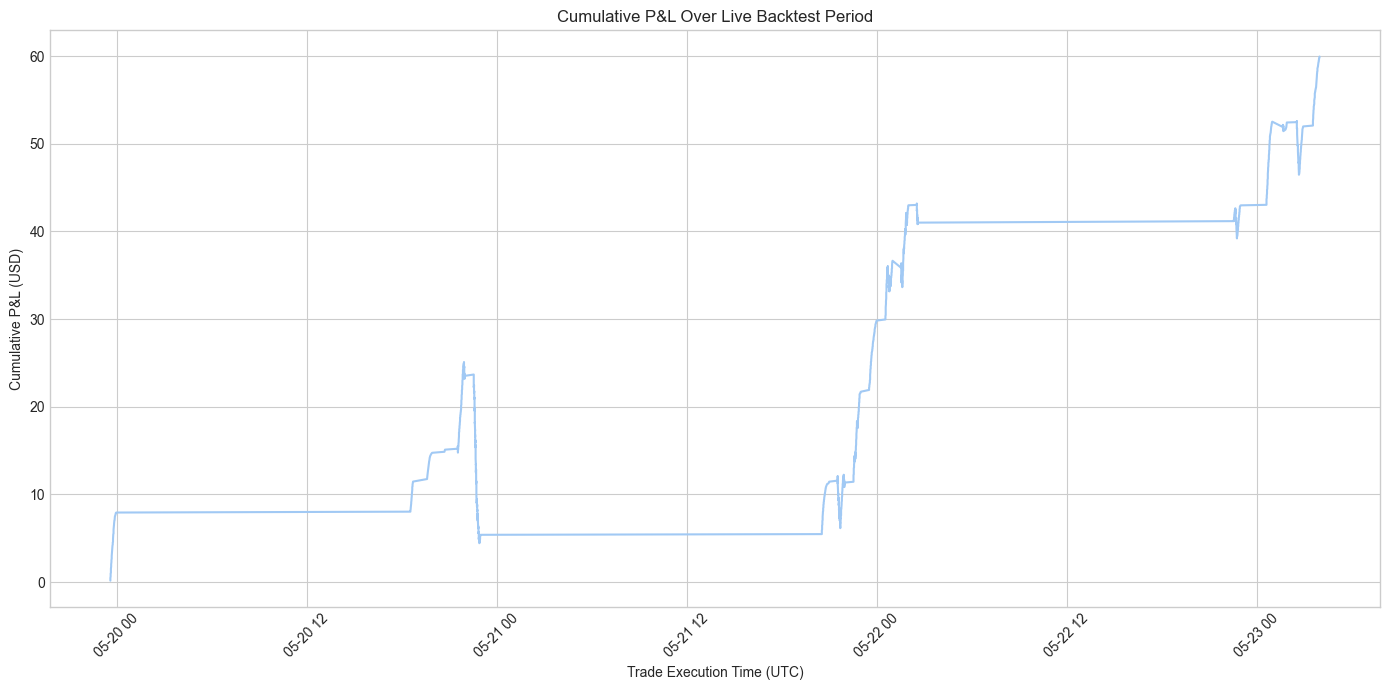

In [4]:
# Cell 4: P&L Over Time (Equity Curve)

if not all_trades_df.empty and 'pnl_cents' in all_trades_df.columns and 'trade_execution_time_utc' in all_trades_df.columns:
    # Ensure pnl_cents is numeric
    all_trades_df['pnl_cents'] = pd.to_numeric(all_trades_df['pnl_cents'], errors='coerce')
    all_trades_df.dropna(subset=['pnl_cents'], inplace=True) # Drop if conversion failed for some reason

    all_trades_df['cumulative_pnl_cents'] = all_trades_df['pnl_cents'].cumsum()
    
    plt.figure(figsize=(14, 7))
    plt.plot(all_trades_df['trade_execution_time_utc'], all_trades_df['cumulative_pnl_cents'] / 100.0) # Convert to USD
    plt.title('Cumulative P&L Over Live Backtest Period')
    plt.xlabel('Trade Execution Time (UTC)')
    plt.ylabel('Cumulative P&L (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    logger_eda_live.warning("Cannot plot equity curve: DataFrame empty or required columns missing/non-numeric.")

2025-05-23 02:34:54,227 - INFO - eda_live_backtest_logs - 
--- Daily Performance (Live Backtest) ---


Daily Performance Summary:


,decision_date,total_trades_daily,total_pnl_usd_daily,avg_pnl_usd_daily,win_rate_daily
0,2025-05-19,50,7.94,0.158800,1.000000
1,2025-05-20,221,-2.54,-0.011493,0.846154
2,2025-05-21,330,24.43,0.074030,0.951515
3,2025-05-22,312,13.14,0.042115,0.894231
4,2025-05-23,187,16.97,0.090749,0.935829


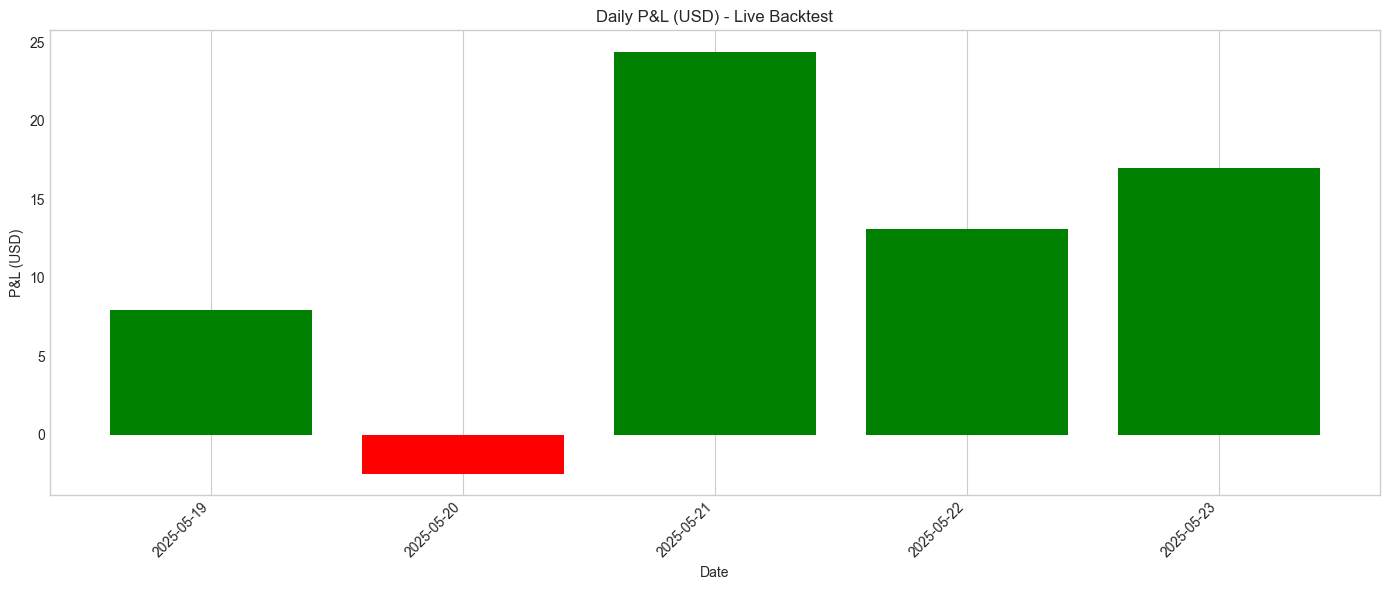

In [5]:
# Cell 5: Performance by Day

if not all_trades_df.empty and 'trade_execution_time_utc' in all_trades_df.columns:
    all_trades_df['decision_date'] = all_trades_df['trade_execution_time_utc'].dt.date
    
    daily_performance = all_trades_df.groupby('decision_date').agg(
        total_trades_daily=('market_ticker', 'count'),
        total_pnl_cents_daily=('pnl_cents', 'sum'),
        avg_pnl_cents_daily=('pnl_cents', 'mean'),
        win_count_daily=('pnl_cents', lambda x: (x > 0).sum()),
        loss_count_daily=('pnl_cents', lambda x: (x < 0).sum())
    ).reset_index()
    
    daily_performance['win_rate_daily'] = daily_performance.apply(
        lambda row: row['win_count_daily'] / row['total_trades_daily'] if row['total_trades_daily'] > 0 else 0, axis=1
    )
    daily_performance['total_pnl_usd_daily'] = daily_performance['total_pnl_cents_daily'] / 100.0
    daily_performance['avg_pnl_usd_daily'] = daily_performance['avg_pnl_cents_daily'] / 100.0
    
    logger_eda_live.info("\n--- Daily Performance (Live Backtest) ---")
    print("Daily Performance Summary:")
    display(daily_performance[['decision_date', 'total_trades_daily', 'total_pnl_usd_daily', 'avg_pnl_usd_daily', 'win_rate_daily']])
    
    # Plot daily P&L
    plt.figure(figsize=(14, 6))
    plt.bar(daily_performance['decision_date'].astype(str), daily_performance['total_pnl_usd_daily'], 
            color=np.where(daily_performance['total_pnl_usd_daily'] >= 0, 'g', 'r'))
    plt.title('Daily P&L (USD) - Live Backtest')
    plt.xlabel('Date')
    plt.ylabel('P&L (USD)')
    plt.xticks(rotation=45, ha='right') # ha='right' for better label alignment
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
    
else:
    logger_eda_live.warning("Cannot analyze daily performance: DataFrame empty or 'trade_execution_time_utc' column missing.")

In [6]:
# Cell 6: Analysis by Trade Action (BUY_YES vs BUY_NO)

if not all_trades_df.empty and 'action' in all_trades_df.columns:
    action_performance = all_trades_df.groupby('action').agg(
        count=('market_ticker', 'size'),
        total_pnl_cents=('pnl_cents', 'sum'),
        avg_pnl_per_trade_cents=('pnl_cents', 'mean'),
        win_count=('pnl_cents', lambda x: (x > 0).sum()),
        loss_count=('pnl_cents', lambda x: (x < 0).sum())
    ).reset_index()
    
    action_performance['win_rate'] = action_performance.apply(
        lambda row: row['win_count'] / (row['win_count'] + row['loss_count']) if (row['win_count'] + row['loss_count']) > 0 else 0, axis=1
    )
    action_performance['total_pnl_usd'] = action_performance['total_pnl_cents'] / 100.0
    action_performance['avg_pnl_per_trade_usd'] = action_performance['avg_pnl_per_trade_cents'] / 100.0
    
    logger_eda_live.info("\n--- Performance by Trade Action (Live Backtest) ---")
    print("Performance by Trade Action:")
    display(action_performance[['action', 'count', 'total_pnl_usd', 'avg_pnl_per_trade_usd', 'win_rate', 'win_count', 'loss_count']])
else:
    logger_eda_live.warning("Cannot analyze by trade action: DataFrame empty or 'action' column missing.")

2025-05-23 02:35:13,057 - INFO - eda_live_backtest_logs - 
--- Performance by Trade Action (Live Backtest) ---


Performance by Trade Action:


,action,count,total_pnl_usd,avg_pnl_per_trade_usd,win_rate,win_count,loss_count
0,BUY_NO,483,27.02,0.055942,0.888199,429,54
1,BUY_YES,617,32.92,0.053355,0.933549,576,41


2025-05-23 02:35:24,576 - INFO - eda_live_backtest_logs - 
--- Predicted Probability Analysis (Live Backtest) ---


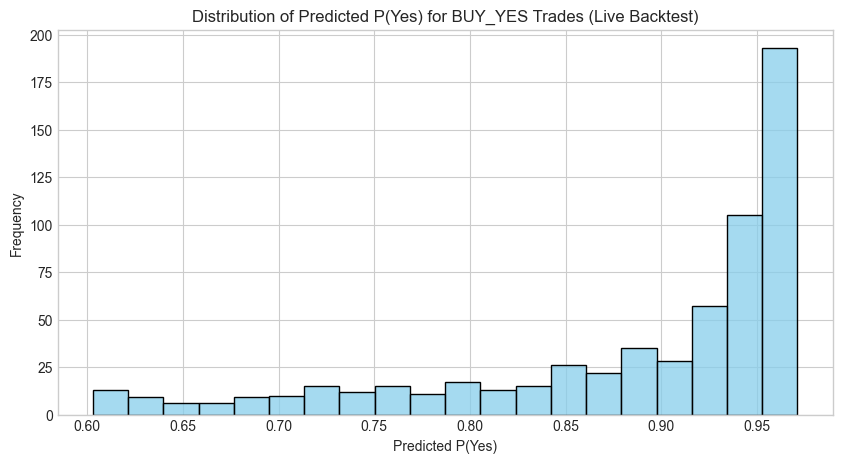

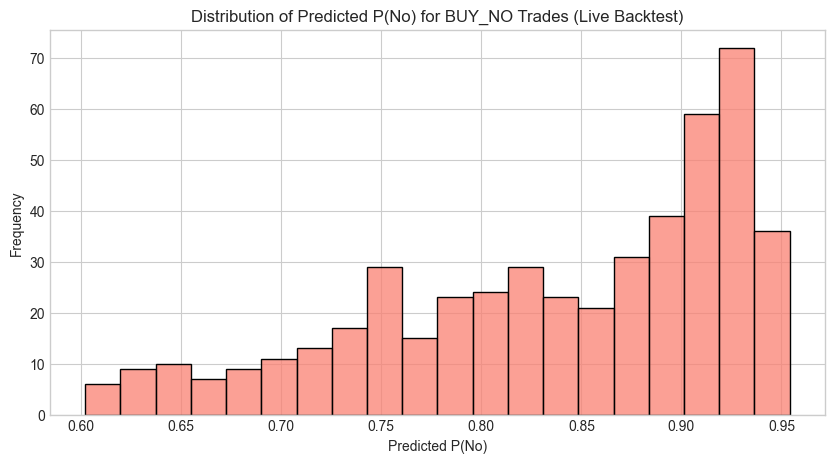

2025-05-23 02:35:24,696 - INFO - eda_live_backtest_logs - 
--- P&L and Win Rate by Binned Model Confidence (in bet direction) (Live Backtest) ---


Performance by Model Confidence Bins:


,prob_bin,count,total_pnl_cents,avg_pnl_cents,win_rate,avg_pnl_usd,total_pnl_usd
0,"[0.6, 0.65)",49,457,9.326531,0.714286,0.093265,4.57
1,"[0.65, 0.7)",40,214,5.350000,0.725000,0.053500,2.14
2,"[0.7, 0.75)",83,-390,-4.698795,0.674699,-0.046988,-3.90
3,"[0.75, 0.8)",102,1051,10.303922,0.872549,0.103039,10.51
4,"[0.8, 0.85)",118,608,5.152542,0.872881,0.051525,6.08
5,"[0.85, 0.9)",159,1110,6.981132,0.943396,0.069811,11.10
6,"[0.9, 0.95)",340,2118,6.229412,0.985294,0.062294,21.18
7,"[0.95, 1.0)",209,826,3.952153,0.995215,0.039522,8.26


In [7]:
# Cell 7: Analysis by Predicted Probability

if not all_trades_df.empty and 'predicted_prob_yes' in all_trades_df.columns:
    logger_eda_live.info("\n--- Predicted Probability Analysis (Live Backtest) ---")
    
    # Ensure predicted_prob_yes is numeric
    all_trades_df['predicted_prob_yes'] = pd.to_numeric(all_trades_df['predicted_prob_yes'], errors='coerce')

    # Distribution of predicted probabilities for BUY_YES trades
    buy_yes_trades = all_trades_df[all_trades_df['action'] == 'BUY_YES'].copy() # Use .copy() to avoid SettingWithCopyWarning
    if not buy_yes_trades.empty and 'predicted_prob_yes' in buy_yes_trades.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(buy_yes_trades['predicted_prob_yes'], bins=20, kde=False, color='skyblue')
        plt.title('Distribution of Predicted P(Yes) for BUY_YES Trades (Live Backtest)')
        plt.xlabel('Predicted P(Yes)')
        plt.ylabel('Frequency')
        plt.show()
    else:
        logger_eda_live.info("No BUY_YES trades or 'predicted_prob_yes' column missing for them.")

    # Distribution of predicted P(No) (1 - P(Yes)) for BUY_NO trades
    buy_no_trades = all_trades_df[all_trades_df['action'] == 'BUY_NO'].copy() # Use .copy()
    if not buy_no_trades.empty and 'predicted_prob_yes' in buy_no_trades.columns:
        buy_no_trades['predicted_prob_no'] = 1 - buy_no_trades['predicted_prob_yes']
        plt.figure(figsize=(10, 5))
        sns.histplot(buy_no_trades['predicted_prob_no'], bins=20, kde=False, color='salmon')
        plt.title('Distribution of Predicted P(No) for BUY_NO Trades (Live Backtest)')
        plt.xlabel('Predicted P(No)')
        plt.ylabel('Frequency')
        plt.show()
    else:
        logger_eda_live.info("No BUY_NO trades or 'predicted_prob_yes' column missing for them.")
        
    # P&L vs. Predicted Probability (binned)
    # Create a 'confidence_in_bet_direction' column
    
    temp_df_for_confidence = all_trades_df.copy() # Work on a copy

    def calculate_confidence(row):
        if pd.isna(row['predicted_prob_yes']): return np.nan
        if row['action'] == 'BUY_YES':
            return row['predicted_prob_yes']
        elif row['action'] == 'BUY_NO':
            return 1 - row['predicted_prob_yes']
        return np.nan # Should not happen if action is only BUY_YES or BUY_NO
        
    temp_df_for_confidence['confidence_in_bet_direction'] = temp_df_for_confidence.apply(calculate_confidence, axis=1)
    
    if 'confidence_in_bet_direction' in temp_df_for_confidence.columns and not temp_df_for_confidence['confidence_in_bet_direction'].isnull().all():
        # Define bins based on your thresholds, e.g., from 0.6 to 1.0
        prob_bins = np.arange(0.6, 1.01, 0.05) # Bins like [0.6, 0.65), [0.65, 0.70), ..., [0.95, 1.00]
        temp_df_for_confidence['prob_bin'] = pd.cut(temp_df_for_confidence['confidence_in_bet_direction'], 
                                                    bins=prob_bins, 
                                                    right=False, # [closed, open) interval
                                                    include_lowest=True) 
    
        binned_pnl = temp_df_for_confidence.groupby('prob_bin', observed=False).agg(
            count=('market_ticker', 'size'),
            total_pnl_cents=('pnl_cents', 'sum'),
            avg_pnl_cents=('pnl_cents', 'mean'),
            win_rate=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
        ).reset_index()
        binned_pnl['avg_pnl_usd'] = binned_pnl['avg_pnl_cents'] / 100.0
        binned_pnl['total_pnl_usd'] = binned_pnl['total_pnl_cents'] / 100.0
        
        logger_eda_live.info("\n--- P&L and Win Rate by Binned Model Confidence (in bet direction) (Live Backtest) ---")
        print("Performance by Model Confidence Bins:")
        display(binned_pnl)
    else:
        logger_eda_live.info("Could not perform binned probability analysis (confidence column missing or all NaN).")
else:
    logger_eda_live.warning("Cannot analyze by predicted probability: DataFrame empty or 'predicted_prob_yes' column missing.")

2025-05-23 02:35:42,291 - INFO - eda_live_backtest_logs - 
--- Performance by Time to Resolution at Decision (Live Backtest) ---
2025-05-23 02:35:42,298 - INFO - eda_live_backtest_logs - 
--- P&L and Win Rate by Time to Resolution Bin (Live Backtest) ---


Performance by Time to Resolution Bins:


,time_to_res_bin,count,total_pnl_usd,avg_pnl_usd,win_rate
0,0-0min,0,0.00,NaN,0.000000
1,1-2min,20,2.05,0.102500,1.000000
2,3-4min,46,1.50,0.032609,0.934783
3,5-9min,164,11.61,0.070793,0.951220
4,10-14min,212,18.61,0.087783,0.952830
5,15-29min,654,25.69,0.039281,0.886850
6,30-59min,4,0.48,0.120000,1.000000


/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_6469/164395178.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=time_binned_performance, x='time_to_res_bin', y='avg_pnl_usd', palette="viridis_r") # Changed palette


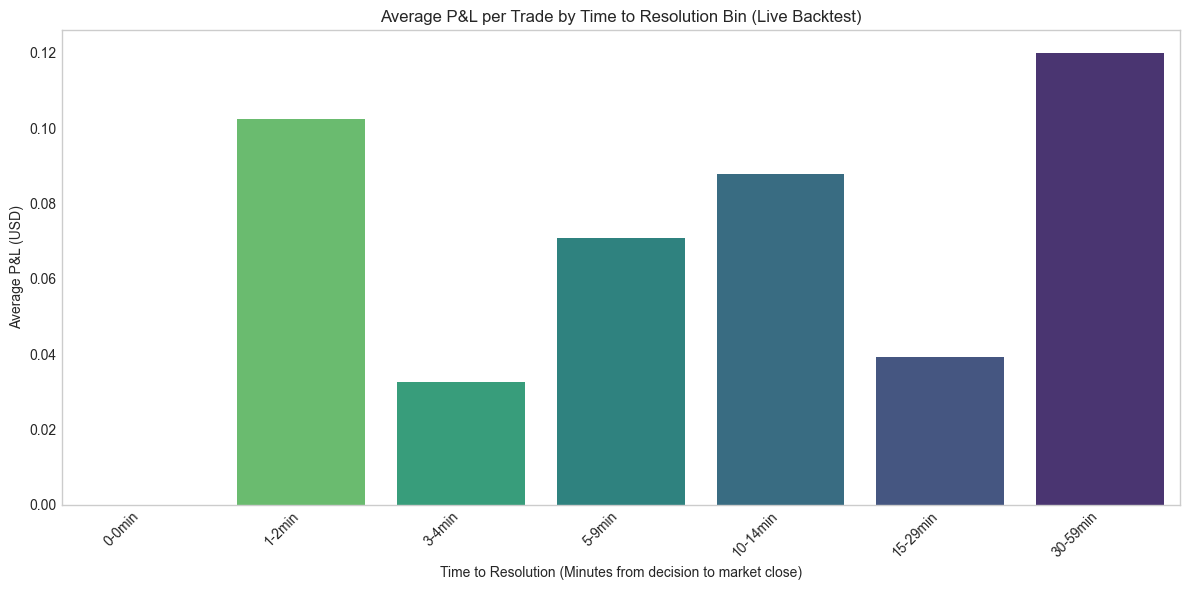

In [8]:
# Cell 8: Analysis by `time_to_resolution_minutes`

if not all_trades_df.empty and 'time_to_resolution_minutes' in all_trades_df.columns:
    logger_eda_live.info("\n--- Performance by Time to Resolution at Decision (Live Backtest) ---")
    
    # Ensure 'time_to_resolution_minutes' is numeric
    all_trades_df['time_to_resolution_minutes'] = pd.to_numeric(all_trades_df['time_to_resolution_minutes'], errors='coerce')
    
    # Define bins for time_to_resolution_minutes.
    # These bins match your historical feature engineering lags, which is a good way to see performance around those key times.
    # Adding 0 at the start and np.inf at the end to capture all values.
    # Example bins for hourly markets (adjust if markets are longer/shorter on average)
    # time_bins = [0, 5, 10, 15, 30, 45, 59, np.inf] 
    # time_labels = ['0-5m', '5-10m', '10-15m', '15-30m', '30-45m', '45-59m', 'Earlier (>=60m)']
    # For consistency with your historical feature eng lag windows:
    
    feature_lag_windows = [1, 3, 5, 10, 15, 30] # from your live_cfg
    # Create bins that cover these points and the ranges between them
    time_bins = sorted(list(set([0] + feature_lag_windows + [60]))) # Add 0 and 60 (max for hourly)
    
    # Create labels dynamically
    time_labels = []
    for i in range(len(time_bins) -1):
        if time_bins[i+1] == 60 and time_bins[i] == 30: # Special label for 30-60
             time_labels.append(f"{time_bins[i]}-{time_bins[i+1]-1}min")
        elif i == len(time_bins) - 2 : # Last bin label (e.g., 30+ min or 60+ min)
            time_labels.append(f"{time_bins[i]}+ min")
        else:
            time_labels.append(f"{time_bins[i]}-{time_bins[i+1]-1}min") # e.g., 0-0min, 1-2min, 3-4min

    # If your markets can be much longer than 1 hour (like the 25-hour one):
    max_time_to_res = all_trades_df['time_to_resolution_minutes'].max()
    if max_time_to_res > 60:
        extended_bins = sorted(list(set(time_bins + [120, 240, 720, np.inf]))) # e.g., up to 2h, 4h, 12h
        time_bins = extended_bins
        # Recreate labels if bins changed
        time_labels = []
        for i in range(len(time_bins)):
            if i == len(time_bins) - 1: # Last bin is just "X+"
                 time_labels.append(f"{int(time_bins[i-1])}+ min")
            elif i == 0:
                 time_labels.append(f"0-{int(time_bins[i+1]-1)}min")
            else:
                 if time_bins[i+1] == np.inf:
                      time_labels.append(f"{int(time_bins[i])}+ min")
                 else:
                      time_labels.append(f"{int(time_bins[i])}-{int(time_bins[i+1]-1)}min")
        if len(time_labels) > len(time_bins) -1: # Adjust if last label duplicated
            time_labels = time_labels[:len(time_bins)-1]


    all_trades_df['time_to_res_bin'] = pd.cut(all_trades_df['time_to_resolution_minutes'], 
                                              bins=time_bins, 
                                              labels=time_labels, 
                                              right=False, # [closed, open) interval
                                              include_lowest=True)

    time_binned_performance = all_trades_df.groupby('time_to_res_bin', observed=False).agg(
        count=('market_ticker', 'size'),
        total_pnl_cents=('pnl_cents', 'sum'),
        avg_pnl_cents=('pnl_cents', 'mean'),
        win_rate=('pnl_cents', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
    ).reset_index()
    time_binned_performance['avg_pnl_usd'] = time_binned_performance['avg_pnl_cents'] / 100.0
    time_binned_performance['total_pnl_usd'] = time_binned_performance['total_pnl_cents'] / 100.0
    
    logger_eda_live.info("\n--- P&L and Win Rate by Time to Resolution Bin (Live Backtest) ---")
    print("Performance by Time to Resolution Bins:")
    display(time_binned_performance[['time_to_res_bin', 'count', 'total_pnl_usd', 'avg_pnl_usd', 'win_rate']])

    # Plot average P&L per trade by time to resolution bin
    plt.figure(figsize=(12, 6))
    sns.barplot(data=time_binned_performance, x='time_to_res_bin', y='avg_pnl_usd', palette="viridis_r") # Changed palette
    plt.title('Average P&L per Trade by Time to Resolution Bin (Live Backtest)')
    plt.xlabel('Time to Resolution (Minutes from decision to market close)')
    plt.ylabel('Average P&L (USD)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()
else:
    logger_eda_live.warning("Cannot analyze by time to resolution: DataFrame empty or 'time_to_resolution_minutes' column missing.")

2025-05-23 02:36:03,126 - INFO - eda_live_backtest_logs - 
--- Misclassification Analysis (Live Backtest) ---
2025-05-23 02:36:03,129 - INFO - eda_live_backtest_logs - Total misclassified trades (based on 0.5 prob threshold): 95 out of 1100
2025-05-23 02:36:03,130 - INFO - eda_live_backtest_logs - False Positives (Predicted YES, was NO): 41
2025-05-23 02:36:03,131 - INFO - eda_live_backtest_logs - False Negatives (Predicted NO, was YES): 54


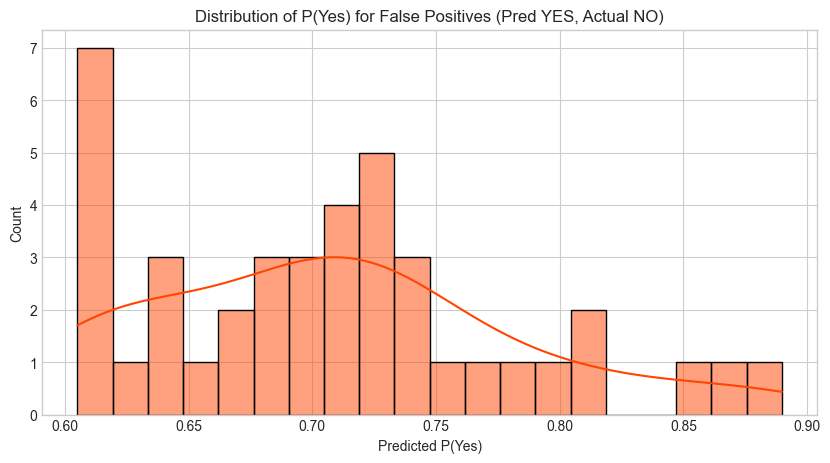

Sample of False Positives:


,market_ticker,decision_timestamp_s,predicted_prob_yes,actual_outcome_target,time_to_resolution_minutes,pnl_cents
166,KXBTCD-25MAY2018-T106749.99,1747778100,0.6320,0,5.0,-63
169,KXBTCD-25MAY2018-T106749.99,1747778160,0.8687,0,4.0,-86
171,KXBTCD-25MAY2018-T106749.99,1747778220,0.6125,0,3.0,-61
429,KXBTCD-25MAY2119-T108999.99,1747866900,0.6382,0,25.0,-63
440,KXBTCD-25MAY2119-T108999.99,1747867080,0.7031,0,22.0,-70


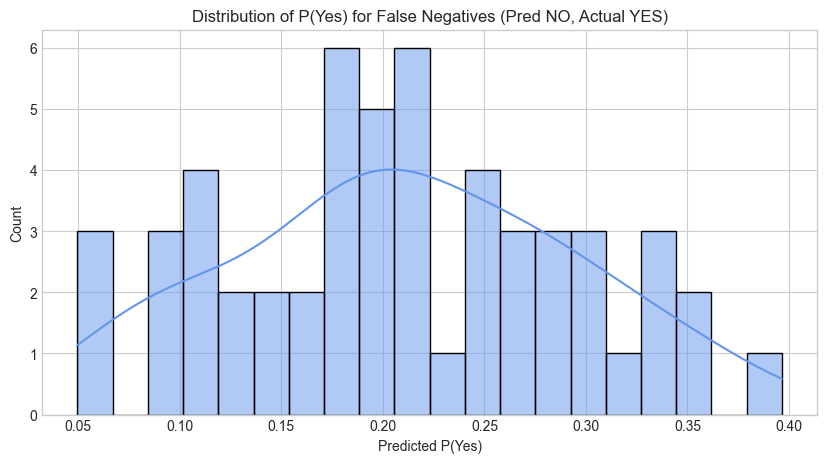

Sample of False Negatives:


,market_ticker,decision_timestamp_s,predicted_prob_yes,actual_outcome_target,time_to_resolution_minutes,pnl_cents
98,KXBTCD-25MAY2018-T106499.99,1747776720,0.2715,1,28.0,-72
175,KXBTCD-25MAY2019-T106749.99,1747780320,0.1502,1,28.0,-84
176,KXBTCD-25MAY2019-T106499.99,1747780320,0.3965,1,28.0,-60
180,KXBTCD-25MAY2019-T106749.99,1747780380,0.1277,1,27.0,-87
183,KXBTCD-25MAY2019-T106749.99,1747780440,0.1175,1,26.0,-88



Misclassifications by Time to Resolution Bin:


,time_to_res_bin,misclassification_count
0,0-0min,0
1,1-2min,0
2,3-4min,3
3,5-9min,8
4,10-14min,10
5,15-29min,74
6,30-59min,0


In [9]:
# Cell 9: Analysis of Misclassifications

if not all_trades_df.empty and 'predicted_prob_yes' in all_trades_df.columns and 'actual_outcome_target' in all_trades_df.columns:
    logger_eda_live.info("\n--- Misclassification Analysis (Live Backtest) ---")
    
    # Create prediction based on 0.5 threshold for simple classification (not trading threshold)
    all_trades_df['simple_prediction'] = (all_trades_df['predicted_prob_yes'] >= 0.5).astype(int)
    
    misclassified_df = all_trades_df[all_trades_df['simple_prediction'] != all_trades_df['actual_outcome_target']].copy()
    
    if not misclassified_df.empty:
        logger_eda_live.info(f"Total misclassified trades (based on 0.5 prob threshold): {len(misclassified_df)} out of {len(all_trades_df)}")

        # False Positives (Predicted YES, Actual NO)
        fp_df = misclassified_df[(misclassified_df['simple_prediction'] == 1) & (misclassified_df['actual_outcome_target'] == 0)]
        # False Negatives (Predicted NO, Actual YES)
        fn_df = misclassified_df[(misclassified_df['simple_prediction'] == 0) & (misclassified_df['actual_outcome_target'] == 1)]

        logger_eda_live.info(f"False Positives (Predicted YES, was NO): {len(fp_df)}")
        logger_eda_live.info(f"False Negatives (Predicted NO, was YES): {len(fn_df)}")

        # What was the model's confidence on these?
        if not fp_df.empty:
            plt.figure(figsize=(10,5))
            sns.histplot(fp_df['predicted_prob_yes'], bins=20, kde=True, color='orangered')
            plt.title('Distribution of P(Yes) for False Positives (Pred YES, Actual NO)')
            plt.xlabel('Predicted P(Yes)')
            plt.show()
            print("Sample of False Positives:")
            display(fp_df[['market_ticker', 'decision_timestamp_s', 'predicted_prob_yes', 'actual_outcome_target', 'time_to_resolution_minutes', 'pnl_cents']].head())
        
        if not fn_df.empty:
            plt.figure(figsize=(10,5))
            sns.histplot(fn_df['predicted_prob_yes'], bins=20, kde=True, color='cornflowerblue')
            plt.title('Distribution of P(Yes) for False Negatives (Pred NO, Actual YES)')
            plt.xlabel('Predicted P(Yes)')
            plt.show()
            print("Sample of False Negatives:")
            display(fn_df[['market_ticker', 'decision_timestamp_s', 'predicted_prob_yes', 'actual_outcome_target', 'time_to_resolution_minutes', 'pnl_cents']].head())
            
        # You can further group misclassifications by 'time_to_res_bin' or other features
        # to see if errors are concentrated in certain regimes.
        if 'time_to_res_bin' in misclassified_df.columns:
            misclassified_by_time = misclassified_df.groupby('time_to_res_bin', observed=False).size().reset_index(name='misclassification_count')
            print("\nMisclassifications by Time to Resolution Bin:")
            display(misclassified_by_time)

    else:
        logger_eda_live.info("No misclassified trades found (based on 0.5 prob threshold) or required columns missing.")
else:
    logger_eda_live.warning("Cannot perform misclassification analysis: DataFrame empty or required columns missing.")

2025-05-23 02:36:19,468 - INFO - eda_live_backtest_logs - 
--- Performance by Individual Kalshi Market (Live Backtest) ---



Top Performing Markets (by total P&L USD):


,market_ticker,num_trades_on_market,total_pnl_usd_market,win_rate_market,avg_pred_prob_yes
1,KXBTCD-25MAY1920-T105749.99,20,4.69,1.000000,0.228685
32,KXBTCD-25MAY2120-T109499.99,28,4.27,1.000000,0.852868
54,KXBTCD-25MAY2221-T111749.99,19,4.17,1.000000,0.215089
62,KXBTCD-25MAY2300-T111249.99,17,4.12,1.000000,0.235700
37,KXBTCD-25MAY2121-T109999.99,25,4.05,1.000000,0.157144
16,KXBTCD-25MAY2117-T108499.99,25,3.87,1.000000,0.150280
23,KXBTCD-25MAY2118-T108749.99,24,3.72,1.000000,0.150758
8,KXBTCD-25MAY2018-T106749.99,27,3.71,0.888889,0.287952
39,KXBTCD-25MAY2122-T109749.99,28,3.67,1.000000,0.874957
28,KXBTCD-25MAY2119-T109249.99,24,3.66,1.000000,0.148200



Worst Performing Markets (by total P&L USD):


,market_ticker,num_trades_on_market,total_pnl_usd_market,win_rate_market,avg_pred_prob_yes
60,KXBTCD-25MAY2223-T111999.99,1,0.10,1.000000,0.094900
56,KXBTCD-25MAY2222-T111499.99,7,-0.84,0.571429,0.400443
47,KXBTCD-25MAY2123-T110499.99,4,-3.02,0.000000,0.757975
50,KXBTCD-25MAY2219-T111249.99,16,-3.11,0.562500,0.405256
36,KXBTCD-25MAY2121-T109749.99,22,-3.39,0.545455,0.501386
59,KXBTCD-25MAY2223-T111499.99,24,-3.91,0.625000,0.374804
40,KXBTCD-25MAY2122-T109999.99,22,-5.02,0.500000,0.477736
13,KXBTCD-25MAY2019-T106499.99,22,-5.15,0.590909,0.642627
22,KXBTCD-25MAY2118-T108499.99,25,-7.62,0.480000,0.483052
14,KXBTCD-25MAY2019-T106749.99,25,-17.11,0.160000,0.268240


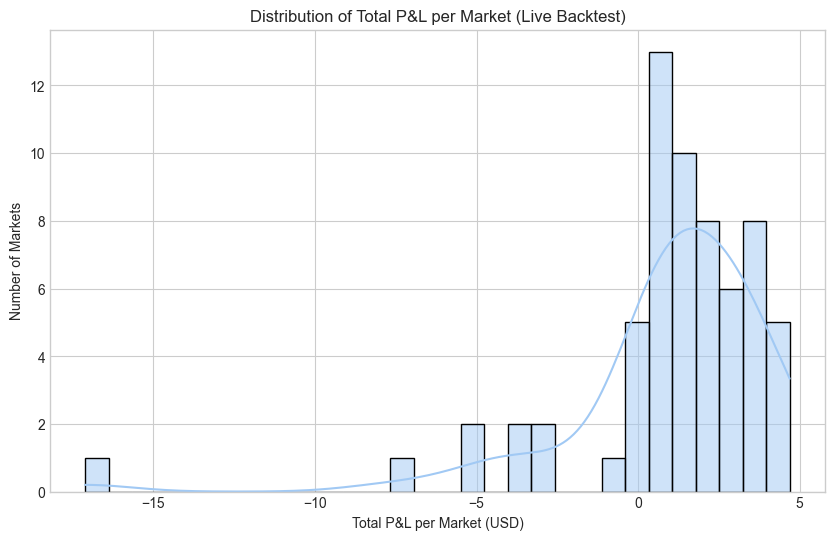

In [10]:
# Cell 10: Market-Level Aggregation (Optional)
# This shows how each individual Kalshi market performed overall if multiple trades were made on it.

if not all_trades_df.empty and 'market_ticker' in all_trades_df.columns:
    logger_eda_live.info("\n--- Performance by Individual Kalshi Market (Live Backtest) ---")
    
    market_level_performance = all_trades_df.groupby('market_ticker').agg(
        num_trades_on_market=('action', 'count'),
        total_pnl_cents_market=('pnl_cents', 'sum'),
        avg_pnl_cents_per_trade_market=('pnl_cents', 'mean'),
        win_count_market=('pnl_cents', lambda x: (x > 0).sum()),
        loss_count_market=('pnl_cents', lambda x: (x < 0).sum()),
        first_trade_time=('trade_execution_time_utc', 'min'),
        last_trade_time=('trade_execution_time_utc', 'max'),
        avg_pred_prob_yes = ('predicted_prob_yes', 'mean') # Avg confidence on this market
    ).reset_index()

    market_level_performance['total_pnl_usd_market'] = market_level_performance['total_pnl_cents_market'] / 100.0
    market_level_performance['win_rate_market'] = market_level_performance.apply(
        lambda row: row['win_count_market'] / row['num_trades_on_market'] if row['num_trades_on_market'] > 0 else 0, axis=1
    )
    
    market_level_performance.sort_values(by='total_pnl_usd_market', ascending=False, inplace=True)
    
    print("\nTop Performing Markets (by total P&L USD):")
    display(market_level_performance[['market_ticker', 'num_trades_on_market', 'total_pnl_usd_market', 'win_rate_market', 'avg_pred_prob_yes']].head(10))
    
    print("\nWorst Performing Markets (by total P&L USD):")
    display(market_level_performance[['market_ticker', 'num_trades_on_market', 'total_pnl_usd_market', 'win_rate_market', 'avg_pred_prob_yes']].tail(10))

    # Distribution of P&L per market
    plt.figure(figsize=(10, 6))
    sns.histplot(market_level_performance['total_pnl_usd_market'], bins=30, kde=True)
    plt.title('Distribution of Total P&L per Market (Live Backtest)')
    plt.xlabel('Total P&L per Market (USD)')
    plt.ylabel('Number of Markets')
    plt.grid(True)
    plt.show()
    
else:
    logger_eda_live.warning("Cannot perform market-level aggregation: DataFrame empty or 'market_ticker' column missing.")